# ELE492 - Homework 2
# Anıl Karaca - 21728405 
I pledge that I have not received or given any aid in this homework. All the work presented below is my own work.

Anıl Karaca - 21728405

## 4-)

### Number of templates we need to detect in the original image:

- Component1: 2
- Component2: 4
- Component3: 2

We need to make total of **8 detections**.

In [1]:
# Importing relevant modules
import cv2
import numpy as np
from matplotlib import pyplot as plt

### **Note:** 
OpenCV uses *BGR* format whereas matplotlib uses *RGB* so we need to convert the images back to *RGB* format.

In [2]:
path="HW2images/" # This is the path where I've stored the images

# Import the images

# Original Input Image
fullImg = cv2.cvtColor(cv2.imread(path+"fullImage.jpg", 1), cv2.COLOR_BGR2RGB)

# Template Images
comps = [cv2.cvtColor(cv2.imread(path+"component1.jpg", 1), cv2.COLOR_BGR2RGB),
         cv2.cvtColor(cv2.imread(path+"component2.jpg", 1), cv2.COLOR_BGR2RGB),
         cv2.cvtColor(cv2.imread(path+"component3.jpg", 1), cv2.COLOR_BGR2RGB)]

In [3]:
# Height, width
H, W = fullImg.shape[:-1]

# Store the heights of the template images in an array
h = [i.shape[0] for i in comps]

# Store the widths of the template images in an array
w = [i.shape[1] for i in comps]

print("Input Image Size:", W, H)
print("Widths of the template images:", w)
print("Heights of the template images:", h)

Input Image Size: 800 533
Widths of the template images: [76, 45, 43]
Heights of the template images: [92, 15, 42]


## Template Matching
There are 6 built-in OpenCV methods to apply *template matching* in total. I've chosen to work with **"cv2.TM_CCOEFF_NORMED"**.

The **threshold** values I've used for this application are:
- Component1: 0.800
- Component2: 0.850
- Component3: 0.807

I could have easily use the same threshold value for all the components but this way we obtain better results.

I've also used different **box colors** for different components for better readability:
- Component1: Blue
- Component2: Green
- Component3: Red

In [4]:
# Now let's detect the templates by using the "cv2.TM_CCOEFF_NORMED" method

def detect(img, templates, printResult = False):
    detections = [] # This list will contain the information of different detected boxes
    img2 = img.copy()
    
    for j in range(len(templates)):
        
        # Recover the original image
        img = img2.copy()

        # We need different threshold values for each template for best results
        if j==0:
            threshold = 0.800
        elif j==1:
            threshold = 0.850
        elif j==2:
            threshold = 0.807

        # Apply template Matching and append the result to a list
        res = cv2.matchTemplate(img, templates[j], cv2.TM_CCOEFF_NORMED)

        # Get the min, max value positions of detections where the score is greater than threshold 
        minMaxPositions = np.where(res >= threshold)

        # Set different colors for different templates(components)
        if j==0:
            color = (0, 0, 255) # Blue
        elif j==1:
            color = (0, 255, 0) # Green
        elif j==2:
            color = (255, 0, 0) # Red

        for (x, y) in zip(minMaxPositions[1], minMaxPositions[0]):
            # We can just use top left and bottom right coordinates to represent a detection box
            
            # Since the detected image will have a size of width(w) x height(h)
            # We can obtain the bottom right corner coordinates as
            top_left = (x, y)
            bottom_right = (x + w[j], y + h[j])

            # Store this detection info in a variable so we can use it later
            detection = {
                "TOP_LEFT": top_left,
                "BOTTOM_RIGHT": bottom_right,
                "SCORE": res[y, x],
                "COLOR": color
            }

            # Store the box coordinates
            detections.append(detection)

            # Apply rectangles on the image to display the detection results
            cv2.rectangle(img, top_left, bottom_right, color, 5)

        # Displaying the result
        if printResult:        
            f, axarr = plt.subplots(1,2)
            axarr[0].title.set_text("Component "+str(j+1))
            axarr[1].title.set_text("Result")
            axarr[0].imshow(img)
            axarr[1].imshow(res)
        else:
            plt.imshow(img)

    img = img2.copy() # Recover the original image
    
    return detections

Total # of detections:  28


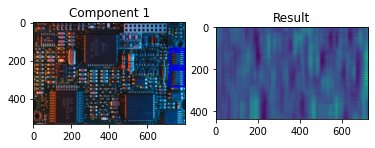

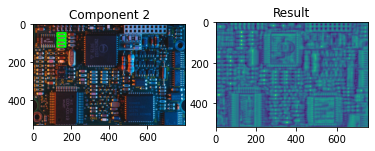

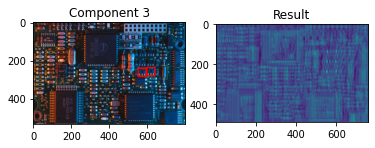

In [5]:
# Let's detect the templates in the original image
detections = detect(fullImg, comps, printResult = True)
print("Total # of detections: ", len(detections))

### **Note:** 
The detections we observe above seem to be correct, but we've detected the same image more than once.

## Computing IoU
In order to tackle this issue we'll start by creating a function to calculate IoU scores, which will later help us to remove the duplicated detection boxes.

In [6]:
# Now we need to tackle the duplicates by removing them by using IoU

def iou(box1, box2, epsilon=1e-5):
    
    # (x1,y1) top left coordinates of the intersection box
    x1 = max(box1["TOP_LEFT"][0], box2["TOP_LEFT"][0])
    y1 = max(box1["TOP_LEFT"][1], box2["TOP_LEFT"][1])
    
    # (x2,y2) bottom right coordinates of the intersection box
    x2 = min(box1["BOTTOM_RIGHT"][0], box2["BOTTOM_RIGHT"][0])
    y2 = min(box1["BOTTOM_RIGHT"][1], box2["BOTTOM_RIGHT"][1])
    
    # Calculate areas for box1 and box2
    area_1 = (box1["BOTTOM_RIGHT"][0] - box1["TOP_LEFT"][0]) * (box1["BOTTOM_RIGHT"][1] - box1["TOP_LEFT"][1])
    area_2 = (box2["BOTTOM_RIGHT"][0] - box2["TOP_LEFT"][0]) * (box2["BOTTOM_RIGHT"][1] - box2["TOP_LEFT"][1])

    # Width and Height of the intersection box
    w, h = (x2 - x1), (y2 - y1)
    
    # When there is no overlap
    if w<0 or h <0:
        return 0.0
    
    # Calculate intersection area
    area_int = w * h
    
    # Calculate combined area of box1 and box2
    area_comb = area_1 + area_2 - area_int

    iou_score = area_int / (area_comb + epsilon)
    
    return iou_score

## Removing Duplicates
In order to remove the duplicated detection boxes we are going to use a method called **Non-max suppression(NMS)**. 

I've found using **0.5** as the **NMS threshold** to be convenient.

The function below basically checks if we have already detected that template by making use of **IoU**, and if we have indeed detected that template earlier it filters the extra one out.

In [7]:
# This method is called "Non-max suppression(NMS)"

def rmv_dup(detections, nms_threshold):
    
    # First we sort the detections with respect to their scores
    sorted_detections = sorted(detections, key=lambda dtc: dtc["SCORE"], reverse=True)
    
    # Initialize the list
    filtered_detections = []
    
    # Check IoU scores for all the detection boxes and filter them
    for dtc in sorted_detections:
        overlap_flag = False
        
        for filtered_dtc in filtered_detections:
            
            # Calculate the IoU score
            iou_score = iou(dtc, filtered_dtc)
            
            if iou_score > nms_threshold:
                # If overlap detected then break to save some time
                overlap_flag = True
                break
                
        # If no overlap detected then don't filter it, and just store it in the new list
        if not overlap_flag:
            filtered_detections.append(dtc)
            
    return filtered_detections

In [8]:
# Now let's create a function to draw the detection boxes on an image

def draw(img, boxes, thickness = 5):
    edited_img = img.copy()
    for box in boxes:
        cv2.rectangle(edited_img, box["TOP_LEFT"], box["BOTTOM_RIGHT"], box["COLOR"], thickness)
    return edited_img

Total # of detections:  8


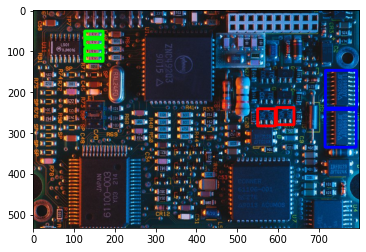

In [9]:
# Filter the detections we have obtained earlier
detections = rmv_dup(detections, 0.5)

# Draw the filtered boxes on the original image
fullImg3 = draw(fullImg, detections)

# Now let's see the final result
print("Total # of detections: ", len(detections))
plt.imshow(fullImg3)

As you can see above this time we have detected all the components exactly the right way.
### Number of templates we have detected in the original image:

- Component1: 2
- Component2: 4
- Component3: 2

We need to make total of **8 detections**

# Comments:
At first, we have used the built-in OpenCV method to detect the template images in the original input image. We have observed this approach has yieled more than one detection boxes for each components, even though the results seemed to be correct.
And then, we have used **Non-max suppression(NMS)** and **Intersection over Union(IoU)** to remove these unwanted duplicates to get the best result possible.

Also, while I was coding this part of the homework, I've realized that selecting the right parameters was really important for the detection of different templates. I've chosen different *detection threshold* values for different templates and I've found using **0.5** as the *NMS threshold* to be convenient.

## 5-)
For the second part of this homework we'll observe the effects of downscaling and rotating a template. 

Since working with only one template is sufficient to see the effect of downscaling and rotating, I've chosen **component1** to work with.

In [10]:
# For the second part of this homework firstly let's downscale the component1 and observe the results
# We'll rescale it to 75% and then we'll rescale that result again to 60%

def downscale(img, scale_percent):
    # Calculate the new dimensions
    w = int(img.shape[1] * scale_percent / 100)
    h = int(img.shape[0] * scale_percent / 100)
    dim = (w, h)
    
    # Resize and return the resulting image
    return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

In [11]:
# Before and after downscaling
print("Shape before downscaling:", comps[0].shape)
comp1_resized = downscale(downscale(comps[0], 75), 60)
print("Shape after downscaling:", comp1_resized.shape)

Shape before downscaling: (92, 76, 3)
Shape after downscaling: (41, 34, 3)


Total # of detections:  0


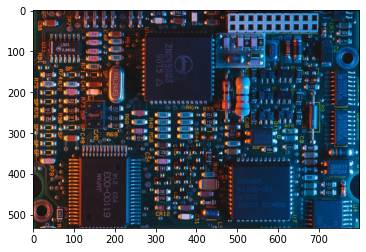

In [12]:
# Now let's detect rescaled component1
detected_comp1_1 = detect(fullImg, [comp1_resized])
print("Total # of detections: ", len(detected_comp1_1))

### **Note:** 
As you can see above we couldn't detect any objects because we have downscaled the image too much. Now we'll try it again but this time we'll downscale it a bit less.

In [13]:
# Now let's try again but this time we'll rescale it by 98% two times in a row

# Before and after downscaling
print("Shape before downscaling:", comps[0].shape)
comp1_resized2 = downscale(downscale(comps[0], 98), 98)
print("Shape after downscaling:", comp1_resized2.shape)

Shape before downscaling: (92, 76, 3)
Shape after downscaling: (88, 72, 3)


Total # of detections:  1


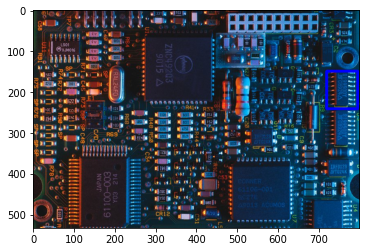

In [14]:
# Now let's detect the rescaled component1 again
detected_comp1_2 = detect(fullImg, [comp1_resized2])
print("Total # of detections: ", len(detected_comp1_2))

As you can see above this time we were able to detect the object once.

# Comments:
We can conclude that downscaling an image can ruin the whole detection process. We need to be really careful when working with template images, because the more you downscale the template image the more you'll miss correct detections.

In [15]:
# For the final part of this homework let's rotate component1 and observe the results once again
# We'll rotate it by 15, 5 and 2 degrees

def rotate(img, angle):
    # Find the coordinates of the center of the image
    center = tuple(np.array(img.shape[1::-1]) / 2)
    
    # Create the transformation matrix
    tf_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Rotate and return the resulting image
    result = cv2.warpAffine(img, tf_matrix, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

Total # of detections:  0


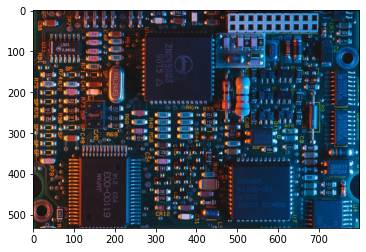

In [16]:
# Now let's see the results for the 15 degrees rotated component1
comp1_rotated = rotate(comps[0], 15)

# Now let's detect the rotated component1 again
detected_comp1_3 = detect(fullImg, [comp1_rotated])
detected_comp1_3 = rmv_dup(detected_comp1_3, 0.5)
print("Total # of detections: ", len(detected_comp1_3))

### **Note:**

As you can see above we couldn't detect any objects because we have rotated it too much.

Total # of detections:  0


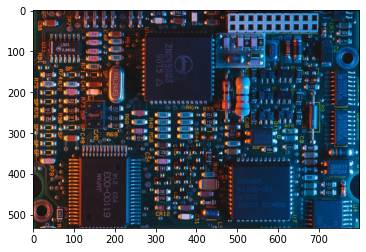

In [17]:
# Now let's see the results for the 5 degrees rotated component1
comp1_rotated2 = rotate(comps[0], 5)
detected_comp1_4 = detect(fullImg, [comp1_rotated2])
detected_comp1_4 = rmv_dup(detected_comp1_4, 0.5)
print("Total # of detections: ", len(detected_comp1_4))

# As you can see below we couldn't detect any objects because we have rotated it too much

### **Note:**

As you can see above we couldn't detect any objects because we have rotated it too much again.

Total # of detections:  2


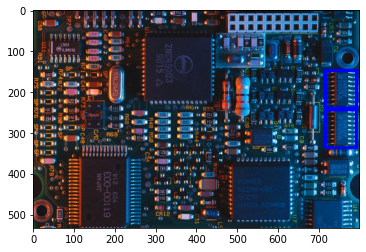

In [18]:
# Now let's see the results for the 2 degrees rotated component1
comp1_rotated3 = rotate(comps[0], 2)
detected_comp1_5 = detect(fullImg, [comp1_rotated3])
detected_comp1_5 = rmv_dup(detected_comp1_5, 0.5)
print("Total # of detections: ", len(detected_comp1_5))

# As you can see below this time we were able to detect two objects

As you can see above this time we were able to detect the object twice.

# Comments: 
We can conclude that rotating an image can ruin the whole detection process. We need to be really careful when working with template images, because the more you rotate the template image the more you'll miss correct detections.